In [1]:
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Toggle Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

In [44]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from umap import UMAP
from friendly_guacamole.datasets import (
    Dataset, QiitaMetadata, QiitaTable,
    HMPV13V35,
)
from friendly_guacamole.transforms import (
    UniFrac,
    CLR,
    AsDense,
    RarefactionBIOM,
    PCoA,
    FilterSamples,
)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [4]:
RAREFACTION_DEPTH = 1000
dataset = HMPV13V35('data/hmpv13v15')


Downloading...Done.


In [5]:
table = dataset['table']
tree = dataset['tree']


In [6]:
preprocessing = Pipeline([
    ('filter_samples', FilterSamples(RAREFACTION_DEPTH))
])

table = preprocessing.fit_transform(table)

In [7]:
table.sum('sample').shape

(8280,)

In [8]:
# import tempfile
# with tempfile.NamedTemporaryFile(mode='w') as f:
#     f.write(tree)
#     f.flush()
#     dm_pipeline = Pipeline([
#         ('subsample', RarefactionBIOM(RAREFACTION_DEPTH)),
#         ('unifrac', UniFrac(f.name)),
#     ])
#     dm = dm_pipeline.fit_transform(table)
dm_pipeline = Pipeline([
    ('subsample', RarefactionBIOM(RAREFACTION_DEPTH)),
    ('unifrac', UniFrac(dataset.apply('tree', 'path'))),
])
dm = dm_pipeline.fit_transform(table)

In [9]:
metadata = dataset['metadata'].set_index('sample_name')
y = metadata.loc[table.ids('sample')]


In [10]:
y.columns

Index(['body_habitat', 'body_product', 'body_site', 'bodysite', 'description',
       'dna_extracted', 'elevation', 'env', 'env_biome', 'env_feature',
       'env_material', 'env_package', 'geo_loc_name', 'host_common_name',
       'host_scientific_name', 'host_subject_id', 'host_taxid', 'latitude',
       'longitude', 'physical_specimen_location',
       'physical_specimen_remaining', 'psn', 'public', 'qiita_study_id',
       'sample_type', 'scientific_name', 'sequencecenter', 'taxon_id', 'title',
       'animations_gradient', 'animations_trajectory'],
      dtype='object')

One component

In [11]:
pcoa_transform = PCoA(metric='precomputed')
X = pcoa_transform.fit_transform(dm)

/Users/garmstro/miniconda3/envs/umap-microbiome-benchmarking/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.8523822003581066 and the largest is 413.0493481679152.
  warn(


In [12]:
U1 = UMAP(metric='precomputed', n_components=1).fit_transform(dm)

/Users/garmstro/miniconda3/envs/umap-microbiome-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


Two component

In [13]:
U2 = UMAP(metric='precomputed', n_components=2, min_dist=0.5).fit_transform(dm)

/Users/garmstro/miniconda3/envs/umap-microbiome-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [82]:
def add_legend(ax, pal, hue_order, patch_kwargs=None, legend_kwargs=None):
    if not legend_kwargs:
        legend_kwargs = dict()
    if not patch_kwargs:
        patch_kwargs = dict()

    palette = sns.color_palette(pal)
    legend_elements = []
    
    for i, name in enumerate(hue_order):
        new_element = Patch(
            facecolor=palette[i % len(palette)],
            label=name,
            **patch_kwargs,
        )
        legend_elements.append(new_element)
        
    legend = ax.legend(handles=legend_elements, **legend_kwargs)
    ax.add_artist(legend)
    return legend

In [83]:
y.columns

Index(['body_habitat', 'body_product', 'body_site', 'bodysite', 'description',
       'dna_extracted', 'elevation', 'env', 'env_biome', 'env_feature',
       'env_material', 'env_package', 'geo_loc_name', 'host_common_name',
       'host_scientific_name', 'host_subject_id', 'host_taxid', 'latitude',
       'longitude', 'physical_specimen_location',
       'physical_specimen_remaining', 'psn', 'public', 'qiita_study_id',
       'sample_type', 'scientific_name', 'sequencecenter', 'taxon_id', 'title',
       'animations_gradient', 'animations_trajectory'],
      dtype='object')

In [84]:
y['body_habitat'].unique()

array(['UBERON:skin', 'UBERON:vagina', 'UBERON:feces',
       'UBERON:oral cavity', 'UBERON:saliva'], dtype=object)

In [94]:
np.where(y['body_site'] == 'tooth', 'tooth', y['body_habitat'])

array(['UBERON:skin', 'UBERON:skin', 'UBERON:skin', ..., 'UBERON:skin',
       'UBERON:skin', 'UBERON:skin'], dtype=object)

In [127]:
y['custom_body_site'] = np.where(y['body_site'] == 'UBERON:tooth', 'UBERON:tooth', y['body_habitat'])
y['custom_body_site'] = np.where(y['body_site'] == 'UBERON:skin of elbow', 'UBERON:skin of elbow', y['custom_body_site'])
y['custom_body_site'] = np.where(y['body_site'] == 'UBERON:skin of external ear', 'UBERON:skin of external ear', y['custom_body_site'])
y['custom_body_site'] = np.where(y['custom_body_site'] == 'UBERON:skin', 'UBERON:skin other', y['custom_body_site'])

# y['custom_body_site'] = np.where(y['body_site'] == 'UBERON:buccal mucosa', 'buccal mucosa', y['custom_body_site'])
# y['custom_body_site'] = np.where(y['body_site'] == 'UBERON:gingiva', 'gingiva', y['custom_body_site'])

In [128]:
hue_var_order

['UBERON:feces',
 'UBERON:oral cavity',
 'UBERON:saliva',
 'UBERON:vagina',
 'skin of elbow',
 'skin of external ear',
 'skin other',
 'tooth']

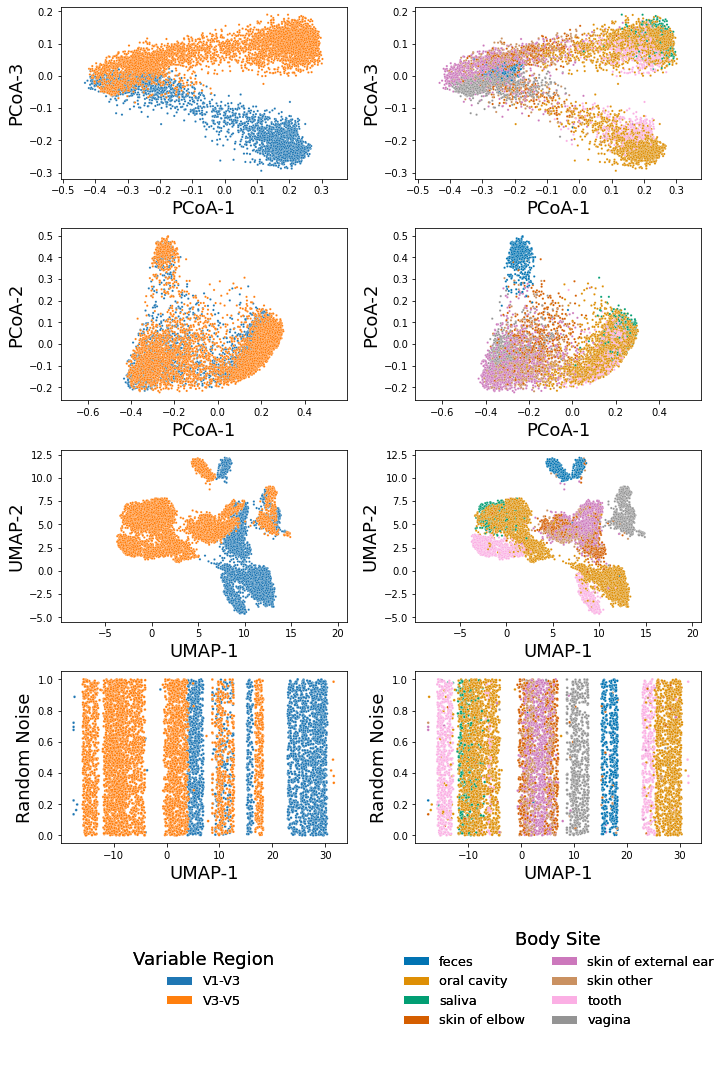

In [142]:
noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(5, 2, figsize=(10, 15))

hue_var = 'custom_body_site'
hue_var_order = list(sorted(y[hue_var].unique().tolist()))
var_order = [1927, 1928]
var_map = {1927: 'V1-V3', 1928: 'V3-V5'}


study_palette = 'tab10'
body_site_palette = 'colorblind'
axis_label_size = 18
g0 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC3'],
    hue=y['qiita_study_id'].tolist(),
    hue_order=var_order,
    ax=axs[0, 0],
    palette=study_palette,
    s=5,
    legend=False,
)
g0.set_aspect('equal', 'datalim')
g0.set_xlabel('PCoA-1', fontsize=axis_label_size)
g0.set_ylabel('PCoA-3', fontsize=axis_label_size)
              
g1 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC3'],
    hue=y[hue_var].tolist(),
    hue_order=hue_var_order,
    ax=axs[0, 1],
    palette=body_site_palette,
    s=5,
    legend=False,
)
g1.set_aspect('equal', 'datalim')
g1.set_xlabel('PCoA-1', fontsize=axis_label_size)
g1.set_ylabel('PCoA-3', fontsize=axis_label_size)

noise_like = np.random.uniform(size=len(U1))
g2 = sns.scatterplot(
    x=pd.Series(U1[:, 0], name='UMAP-1'),
    y=noise_like,
    palette=study_palette,
    hue=y['qiita_study_id'].tolist(),
    hue_order=var_order,
    s=7,
    ax=axs[3, 0],
    legend=False,
)
g2.set_xlabel('UMAP-1', fontsize=axis_label_size)
g2.set_ylabel('Random Noise', fontsize=axis_label_size)


g3 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC2'],
    hue=y['qiita_study_id'].tolist(),
    hue_order=var_order,
    ax=axs[1, 0],
    palette=study_palette,
    s=5,
    legend=False,
)
g3.set_xlabel('PCoA-1', fontsize=axis_label_size)
g3.set_ylabel('PCoA-2', fontsize=axis_label_size)
g3.set_aspect('equal', 'datalim')

g4 = sns.scatterplot(
    x=pd.Series(U2[:, 0], name='UMAP-1'),
    y=pd.Series(U2[:, 1], name='UMAP-2'),
    hue=y['qiita_study_id'].tolist(),
    hue_order=var_order,
    palette=study_palette,
    ax=axs[2, 0],
    s=5,
    legend=False,
)
g4.set_xlabel('UMAP-1', fontsize=axis_label_size)
g4.set_ylabel('UMAP-2', fontsize=axis_label_size)
g4.set_aspect('equal', 'datalim')


g5 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC2'],
    hue=y[hue_var].tolist(),
    hue_order=hue_var_order,
    ax=axs[1, 1],
    palette=body_site_palette,
    s=5,
    legend=False
)
g5.set_xlabel('PCoA-1', fontsize=axis_label_size)
g5.set_ylabel('PCoA-2', fontsize=axis_label_size)
g5.set_aspect('equal', 'datalim')
g6 = sns.scatterplot(
    x=pd.Series(U2[:, 0], name='UMAP-1'),
    y=pd.Series(U2[:, 1], name='UMAP-2'),
    hue=y[hue_var].tolist(),
    hue_order=hue_var_order,
    palette=body_site_palette,
    ax=axs[2, 1],
    s=5,
    legend=False,
)
g6.set_xlabel('UMAP-1', fontsize=axis_label_size)
g6.set_ylabel('UMAP-2', fontsize=axis_label_size)
g6.set_aspect('equal', 'datalim')

g7 = axs[4, 0]
g7.axis('off')
add_legend(g7, study_palette, [var_map[var] for var in var_order],
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='center',
               fontsize=13, ncol=1, framealpha=0.0, 
               title='Variable Region',
               title_fontsize=axis_label_size,
           )
)

g9 = axs[4, 1]
varmap = pd.Series(hue_var_order).str.replace('UBERON:', '')
add_legend(g9, body_site_palette, varmap.tolist(),
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='center',
               fontsize=13, ncol=2, framealpha=0.0, 
               title='Body Site',
               title_fontsize=axis_label_size,
           )
)

g8 = sns.scatterplot(
    x=pd.Series(U1[:, 0], name='UMAP-1'),
    y=noise_like,
    palette=body_site_palette,
    hue=y[hue_var].tolist(),
    hue_order=hue_var_order,
    s=7,
    ax=axs[3, 1],
    legend=False,
)
g8.set_xlabel('UMAP-1', fontsize=axis_label_size)
g8.set_ylabel('Random Noise', fontsize=axis_label_size)


# g9 = sns.scatterplot(
#     x=pd.Series(U2[:, 0], name='UMAP-1'),
#     y=pd.Series(U2[:, 1], name='UMAP-2'),
#     hue=y['body_site'].tolist(),
#     palette=body_site_palette,
#     ax=axs[4, 1],
#     s=5,
# #     legend=False,
# )
# g9.set_xlabel('UMAP-1', fontsize=axis_label_size)
# g9.set_ylabel('UMAP-2', fontsize=axis_label_size)
# g9.set_aspect('equal', 'datalim')
g9 = axs[4, 1]
g9.axis('off')


plt.tight_layout()
plt.savefig('results/hmp-body-site-full-panel-batch-effect.png', dpi=300)
plt.show()